# TMDb电影数据分析 & 电影评分预测

### 前言

Hi! 这是我的第一个数据分析项目，展示了问题分解、数据清洗、数据分析与可视化的过程，最后给出了一个简单的预测模型。我从中学到了很多，在此分享出来，请多多指教！

数据来源是Kaggle提供的Internet Movie Database（TMDb）数据集，包括了近五千部电影的信息。  
数据原地址：https://www.kaggle.com/tmdb/tmdb-movie-metadata

本文的框架如下：
1. 准备工作  
1.1 数据载入和预览  
1.2 数据清洗和加工  
1.3 数据筛选  
2. 票房 & 评分分析  
2.0 概览（票房&评分Top 10、变化趋势）  
2.1 类型（不同类型影片的数量变化趋势、票房&评分）  
2.2 导演（Top 10、票房&评分分布）  
2.3 主演（Top 10、票房&评分分布）  
2.4 档期（数量分布、票房分布）  
2.5 有趣的发现
3. 电影评分预测  
3.1 相似度计算  
3.2 评分预测

## 1 - 准备工作

### 1.1 - 数据载入和预览

数据分析包导入：

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

数据导入。这个数据集是标准的CSV格式，直接用pd.read_csv就能读取：

In [2]:
file = r'C:\Users\youji\Downloads\TMDB Movies\tmdb_5000_movies.csv'
movies = pd.read_csv(file)
file = r'C:\Users\youji\Downloads\TMDB Movies\tmdb_5000_credits.csv'
credits = pd.read_csv(file)

数据预览：

In [3]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [5]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [6]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
movie_id    4803 non-null int64
title       4803 non-null object
cast        4803 non-null object
crew        4803 non-null object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


可以看到这两个数据集提供了4803部电影的预算、票房、评分、职员表等诸多信息，而且数据比较完整（缺失值很少）。

### 1.2 - 数据清洗和加工

数据清洗主要包括查漏补缺、去重、纠错。
- 查漏补缺：数据集中homepage、runtime、tagline有缺失，但它们也不是我们关心的信息，可以忽略。
- 纠错：目前看不出有没有错误，在后续分析中再考虑。
- 去重：movies数据集中的id是每部电影的识别码，以此来看看有没有重复数据：

In [7]:
len(movies.id.unique())

4803

有4803个不重复的id，可以认为没有重复数据。

数据加工主要是对一些字段进行提取和转换。
两个数据集都有电影id，用merge将两个表合并：

In [8]:
movies_credits = movies.merge(credits, left_on = 'id', right_on = 'movie_id', how = 'left')

从预览中可以观察到，genres（类型）、keywords（关键词）、cast（职员表）这些数据都是json格式的，我们实际需要的是name字段对应的名字，因此将这些数据转为名字列表方便后续分析。

In [9]:
movies_credits.genres[0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

首先使用json.loads对数据进行读取：

In [10]:
import json
json_columns = ['genres', 'keywords', 'production_companies', 'production_countries', 'cast', 'crew']
for column in json_columns:
    movies_credits[column] = movies_credits[column].apply(json.loads)

将数据中name字段对应的名字提取出来，用列表推导式可以简洁地构造提取函数：

In [11]:
def extractName(column):
    col = [[di['name'] for di in row] for row in column]
    return col
ex_name = ['genres', 'production_companies', 'production_countries']
for column in ex_name:
    movies_credits[column] = extractName(movies_credits[column])
movies_credits['actors'] = [[di['name'] for di in row[0:4]] for row in movies_credits['cast']]    #演员只取前4位
movies_credits['keywords'] = [[di['name'] for di in row[0:10]] for row in movies_credits['keywords']]    #关键词只取前10个

现在genres等列变为名字列表了：

In [12]:
movies_credits.genres[0]

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

导演、编剧和制片人信息储存在crew一列中，将其提取出来。对于crew中没有该职位的情况，用空值代替：

In [13]:
def extractDirector(crew, job):
    name = ''
    for di in crew:
        if di['job'] == job:
            name = di['name']
            break 
        else:
            pass
    return name
movies_credits['director'] = [extractDirector(crew, 'Director') for crew in movies_credits.crew]
movies_credits['writer'] = [extractDirector(crew, 'Writer') for crew in movies_credits.crew]
movies_credits['producer'] = [extractDirector(crew, 'producer') for crew in movies_credits.crew]

提取电影发布时间（release_date）一列中的年份，方便后续按年份来统计：

In [14]:
movies_credits['year'] = pd.to_datetime(movies_credits['release_date']).apply(lambda x: x.year)

### 1.3 - 数据筛选

提取出我们后续分析需要的变量，去掉空值，看看数学统计：

In [15]:
movies = movies_credits[['title_x', 'genres', 'keywords', 'director', 'actors', 'writer', 'producer', 'budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'production_companies', 'production_countries', 'year']].dropna()
movies.rename(columns={'title_x': 'title'}, inplace = True)
movies.year = movies.year.astype(int)
movies.describe()

,budget,revenue,popularity,vote_average,vote_count,year
count,4.802000e+03,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000
mean,2.905109e+07,8.227777e+07,21.496776,6.093440,690.361724,2002.468763
std,4.072447e+07,1.628697e+08,31.818451,1.191496,1234.674268,12.414354
min,0.000000e+00,0.000000e+00,0.000372,0.000000,0.000000,1916.000000
25%,8.000000e+05,0.000000e+00,4.671734,5.600000,54.000000,1999.000000
50%,1.500000e+07,1.917498e+07,12.924931,6.200000,235.500000,2005.000000
75%,4.000000e+07,9.291920e+07,28.332017,6.800000,737.000000,2011.000000
max,3.800000e+08,2.787965e+09,875.581305,10.000000,13752.000000,2017.000000


评分人数（vote_count）过低的电影，其评分（vote_average）也不具有统计意义，这里筛选评分人数大于40的数据。其他票房、预算等为0的数据也应该筛去。此外，电影上映年份的跨度很大，如果考虑很大的时间跨度，会引入诸多影响因子（例如通货膨胀对票房金额的影响），不利于发现规律，因此有必要筛选以缩小研究范围。这里截取2000年之后的数据：

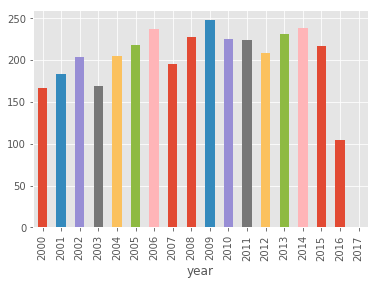

In [16]:
movies[movies.year >= 2000].groupby('year').size().plot(kind = 'bar')

从图上看，每年的电影数量都在200部左右（实际上映电影数量更多，说明该数据有一定的局限性），但是2016年的数据远小于200部，可以认为该数据集并未收集全2016年的数据。因此，我们的研究范围限制在2000年至2015年之间：

In [17]:
movies_15 = movies[(movies.year >= 2000) & (movies.year < 2016) & (movies.vote_count > 40) &(movies.budget * movies.revenue * movies.popularity * movies.vote_average !=0)].reset_index(drop = 'True')

## 2 - 票房 & 评分分析

这个数据集提供了丰富的信息，可以从多种维度进行分析。下面我的分析主要是为了回答这个问题：<b>怎样的电影更有可能成功？</b>成功的定义可以有两种：高票房或者高评分，而影响成功的因素有不少，例如影片类型、导演、主演、档期等，我将对它们逐个进行分析。

### 2.0 - 票房和评分概览

#### 2.0.1 - 票房Top 10

In [18]:
movies_15.sort_values('revenue', ascending=False)[['title', 'revenue', 'budget', 'genres']][0:10]

,title,revenue,budget,genres
0,Avatar,2787965087,237000000,"[Action, Adventure, Fantasy, Science Fiction]"
15,The Avengers,1519557910,220000000,"[Science Fiction, Action, Adventure]"
25,Jurassic World,1513528810,150000000,"[Action, Adventure, Science Fiction, Thriller]"
41,Furious 7,1506249360,190000000,[Action]
7,Avengers: Age of Ultron,1405403694,280000000,"[Action, Adventure, Science Fiction]"
109,Frozen,1274219009,150000000,"[Animation, Adventure, Family]"
28,Iron Man 3,1215439994,200000000,"[Action, Adventure, Science Fiction]"
440,Minions,1156730962,74000000,"[Family, Animation, Adventure, Comedy]"
49,Transformers: Dark of the Moon,1123746996,195000000,"[Action, Science Fiction, Adventure]"
281,The Lord of the Rings: The Return of the King,1118888979,94000000,"[Adventure, Fantasy, Action]"


1. 这10部影片预算是亿级（美元）的，票房是十亿级的，属于高投入高收入的影片。
2. 有8部是动作/科幻片，2部动画片，显然电影类型对票房是有影响的，那么是不是动作/科幻片就一定带来高票房呢？后面会进行相关分析。

#### 2.0.2 票房、预算和投资回报率（ROI）变化趋势

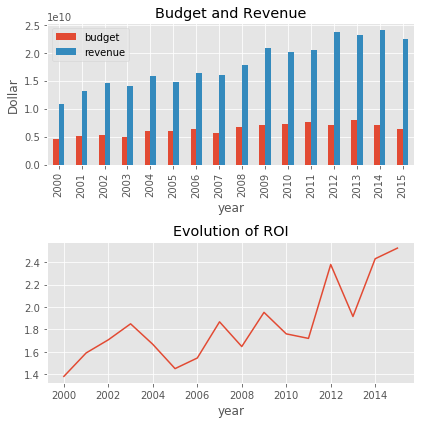

In [19]:
b_r = movies_15.groupby('year')['budget', 'revenue'].sum()
b_r['ROI'] = (b_r.revenue - b_r.budget) / b_r.budget
#作图：
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
b_r.iloc[:, 0:2].plot(kind='bar', ax=axes[0], title='Budget and Revenue')
axes[0].set_ylabel('Dollar')
b_r.ROI.plot(ax=axes[1], title='Evolution of ROI')
fig.tight_layout()

2000年至2015年间，电影制作的经费投入并没有显著增长，但票房收入呈上升趋势，相应地，ROI从2000年的1.4升到了2015年的2.5，电影行业正处于稳步上升的阶段。

#### 2.0.3 - 评分Top 10

In [20]:
movies_15.sort_values('vote_average', ascending=False)[['title', 'vote_average', 'genres']][0:10]

,title,vote_average,genres
1980,Whiplash,8.3,[Drama]
1457,Spirited Away,8.3,"[Fantasy, Adventure, Animation, Family]"
59,The Dark Knight,8.2,"[Drama, Action, Crime, Thriller]"
1303,Howl's Moving Castle,8.2,"[Fantasy, Animation, Adventure]"
1981,City of God,8.1,"[Drama, Crime]"
83,Interstellar,8.1,"[Adventure, Drama, Science Fiction]"
84,Inception,8.1,"[Action, Thriller, Science Fiction, Mystery, A..."
1662,Room,8.1,"[Drama, Thriller]"
281,The Lord of the Rings: The Return of the King,8.1,"[Adventure, Fantasy, Action]"
1914,Memento,8.1,"[Mystery, Thriller]"


（可能由于时间原因，目前IMDb网站上这些影片的评分与这个数据集中的评分有一点差别）  
1. 票房Top 10中只有《指环王：王者归来》出现在了评分Top 10的榜单上，票房和评分可能没有很强的关联性。
2. 这10部片的类型也是五花八门，似乎没有很明显的特征。  
这两点有待后面进行更深入的分析。

#### 2.0.4 - 评分总体变化趋势

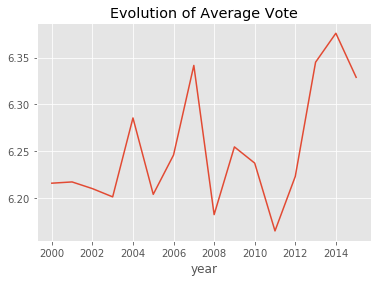

In [21]:
vote_by_year = movies_15.groupby('year').vote_average.mean()
vote_by_year.plot(title = 'Evolution of Average Vote')

电影评分随年份变化的趋势不明显，总体上在6.25上下小幅度波动。

#### 2.0.5 - 票房和评分的影响因素（数值型变量）

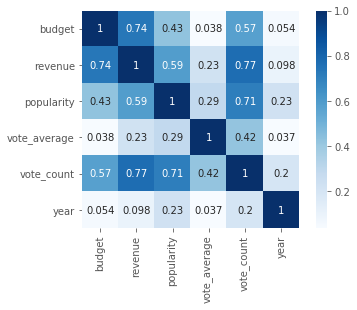

In [22]:
import seaborn as sns
sns.heatmap(movies_15.corr(), annot=True, vmax=1, square=True, cmap="Blues")

1. 票房与预算、评论数的相关性较大，但评论数和票房一样，只能等到电影上映后才知道具体数值。
2. 评分与票房、预算、热度、评论数的相关性都不大。

### 2.1 - 影片类型的影响

#### 2.1.1 - 影片类型的变化趋势

一部电影可归为多种类型，先统计一下各种类型出现的次数。通过定义一个计数函数来实现：

In [23]:
def countN(column):
    count = dict()
    for row in column:
        for ele in row:
            if ele in count:
                count[ele] += 1
            else:
                count[ele] = 1
    return count

每种类型出现的次数除以总的影片数，以此作为该种类型的频数百分比：

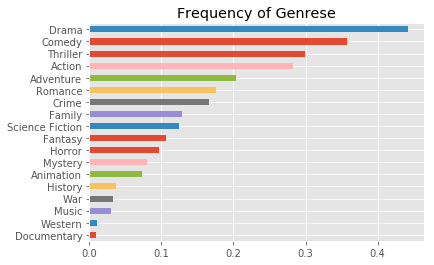

In [24]:
genres = pd.Series(countN(movies_15.genres)).sort_values()
genres_avg = genres / len(movies_15)
genres_avg.plot(kind = 'barh', title = 'Frequency of Genrese')

1. 影片有18种类型，剧情、喜剧、惊悚、动作这4种类型的影片最多，西部片和纪录片最少。
2. 每100部影片中就有约45部属于剧情片，是大家拍摄电影的首选。  

选取前9种类型，观察它们在这15年间每年的数量与当年影片总数之比的变化：

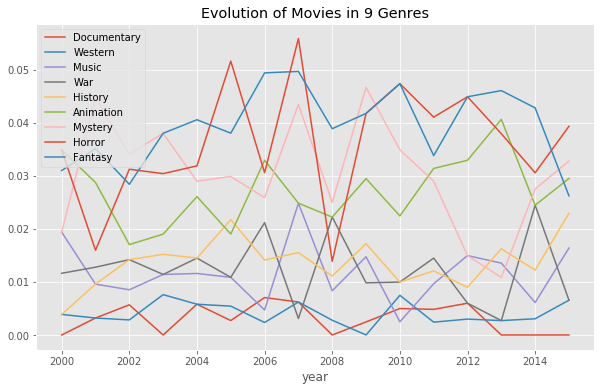

In [25]:
genres_by_year = movies_15.groupby('year').genres.sum()
genres_count = pd.DataFrame([], index = genres_by_year.index, columns = genres.index[0:9])
for g in genres_count.columns:
    for y in genres_count.index:
        genres_count.loc[y,g] = genres_by_year[y].count(g) / len(genres_by_year[y])
genres_count.plot(figsize = (10,6), title = 'Evolution of Movies in 9 Genres')

1. 各种类型的数量占比有一定的浮动，但总体趋势变化不大。
2. 剧情片一直是拍摄电影的首选，近年来还有上涨的态势。
3. 近年来喜剧片的占比下滑，冒险类的占比升高。

#### 2.1.2 - 不同类型影片的票房

计算方法：票房的影响因素有很多，这里单纯考虑类型对票房的影响。对于某种类型，计算所有该类影片的票房，再除以该类影片的数量。对于预算也采用同样的计算方法。

In [26]:
movies_by_genres = pd.DataFrame(0, index = genres.index, columns = ['revenue', 'budget', 'vote'])
for i in range(len(movies_15)):
    for g in movies_15.genres[i]:
        movies_by_genres.loc[g, 'revenue'] += movies_15.revenue[i]    #该类影片的总票房
        movies_by_genres.loc[g, 'budget'] += movies_15.budget[i]    #该类型影片的总均预算
        movies_by_genres.loc[g, 'vote'] += movies_15.vote_average[i]    #该类型影片的总评分
movies_by_genres = movies_by_genres.div(genres.values, axis=0)
movies_by_genres['ROI'] = (movies_by_genres.revenue - movies_by_genres.budget) / movies_by_genres.budget

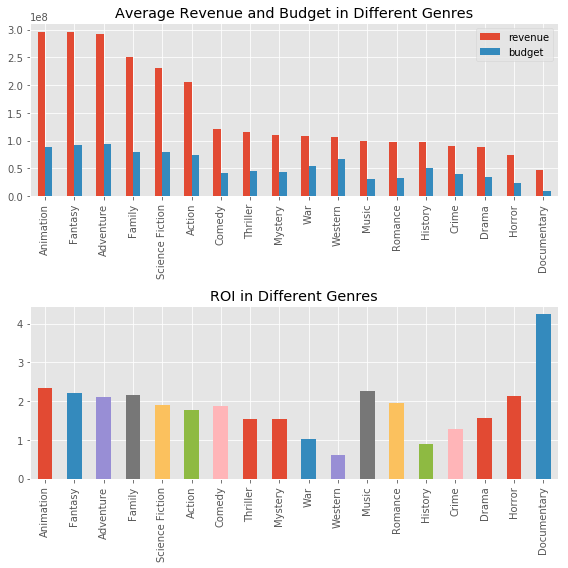

In [27]:
#作图：
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
movies_by_genres.sort_values('revenue', ascending=False)[['revenue', 'budget']].plot(ax=axes[0], kind = 'bar', title='Average Revenue and Budget in Different Genres')
movies_by_genres.sort_values('revenue', ascending=False)['ROI'].plot(ax=axes[1], kind = 'bar', title='ROI in Different Genres')
fig.tight_layout()

1. 票房最高的影片类型是：动画、奇幻和冒险，其次是家庭、科幻和动作，它们比其余类型影片的票房高了一大截，当然它们的预算也相对较高。
2. 票房高的影片类型，其投资回报率也是不错的。
3. 剧情片和喜剧虽然热门（影片数量多），但投资回报率表现平平。
4. 投资回报率最高的是较为小众的纪录片，如果预算有限又想获得高收益，纪录片不失为一个好选择。
5. 西部片、历史片和战争片的投资回报率垫底，拍摄此类影片需谨慎。

影片类型对票房的影响，还可以进行更深入的分析，比如：科幻+剧情的影片是否比单纯的科幻片或单纯的剧情片有更高的投资回报率？我们算一下看看：

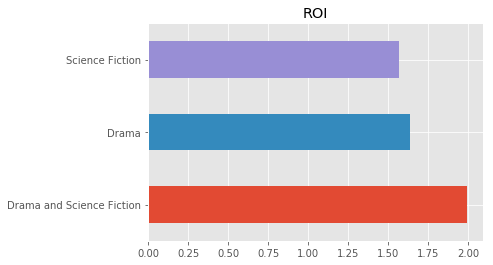

In [28]:
genres_c = pd.Series()
movies_dra_sci = movies_15[movies_15.genres.str.contains('Action', regex=False) & movies_15.genres.str.contains('Science Fiction', regex=False)]    #科幻+剧情
genres_c['Drama and Science Fiction'] = (movies_dra_sci.revenue.sum() - movies_dra_sci.budget.sum()) / movies_dra_sci.budget.sum()
movies_dra = movies_15[movies_15.genres.str.contains('Action', regex=False) & ~movies_15.genres.str.contains('Science Fiction', regex=False)]    #只有剧情
genres_c['Drama'] = (movies_dra.revenue.sum() - movies_dra.budget.sum()) / movies_dra.budget.sum()
movies_sci = movies_15[~movies_15.genres.str.contains('Action', regex=False) & movies_15.genres.str.contains('Science Fiction', regex=False)]    #只有科幻
genres_c['Science Fiction'] = (movies_sci.revenue.sum() - movies_sci.budget.sum()) / movies_sci.budget.sum()
genres_c.plot(kind = 'barh', title = 'ROI')

科幻+剧情的影片确实比单纯的科幻片有着更高的投资回报率，因此，拍摄科幻片的时候不能一味地追求特效而忽略的剧本的质量，否则会对投资回报率造成负面影响。  
其他类型叠加的效果也可以进行类似的分析，这里就不再展开了。

#### 2.1.3 - 不同类型影片的评分

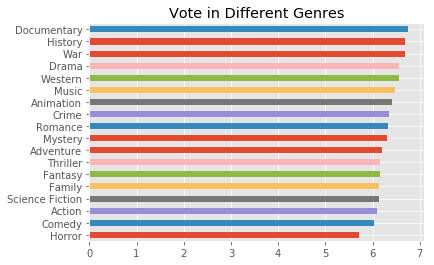

In [29]:
movies_by_genres.sort_values('vote').vote.plot(kind = 'barh', title='Vote in Different Genres')

1. 不同类型影片的评分差距较小，极差约为1分。
2. 纪录片、历史片和战争片的评分位列前三。动作片、喜剧片和恐怖片的评分位列倒数前三。

### 2.2 - 影片导演的影响

#### 2.2.1 - 导演的票房分布

In [30]:
revenue_of_director = movies_15.groupby('director').revenue.mean()    #平均票房

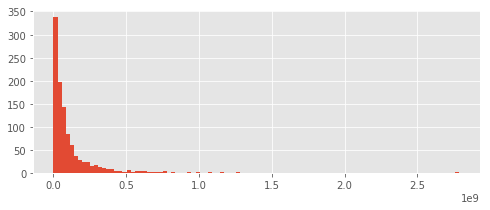

In [31]:
revenue_of_director.hist(bins=100, figsize=(8,3))

典型的长尾分布，极少数导演的吸金能力特别强，下一节我们来看下他们是谁。

#### 2.2.2 - 票房最高的导演Top 10

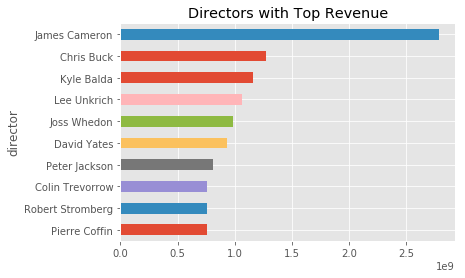

In [32]:
revenue_of_director.sort_values().tail(10).plot(kind = 'barh', title = 'Directors with Top Revenue')

卡梅隆导演一枝独秀，由他执导的影片的票房远远超过了其他导演。第二至四名都是动画片导演，从前面的分析我们已得知，动画片是平均票房最高的影片类型，因此这几位导演未必真的比拍其他类型影片的导演更有吸金能力，而可能只是有动画片这个类型的加成。若要排除类型的干扰，可以分类型进行排序。例如，我们看一下科幻片中吸金能力最强的导演：

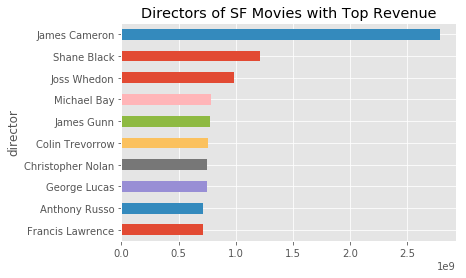

In [33]:
revenue_director_genres = movies_15[movies_15.genres.str.contains('Science Fiction', regex=False)].groupby('director').revenue.mean()
revenue_director_genres.sort_values().tail(10).plot(kind = 'barh', title = 'Directors of SF Movies with Top Revenue')

除了卡梅隆，执导《钢铁侠3》的沙恩布莱克等人也是较为优秀的科幻片导演。

#### 2.2.3 - 导演的评分分布

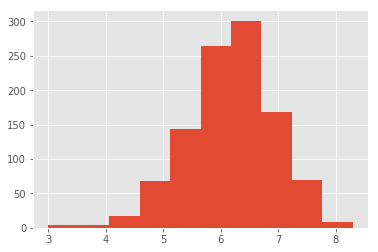

In [34]:
vote_of_director = movies_15.groupby('director').vote_average.mean()    #平均评分
vote_of_director.hist()

导演的评分近似正态分布，在6-7分之间的人最多。

#### 2.2.4 - 评分最高的导演Top 10

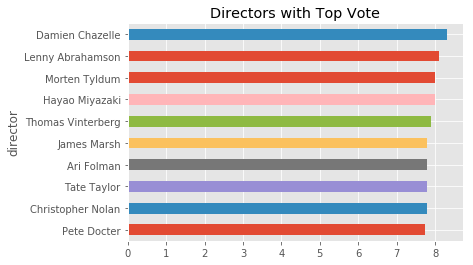

In [35]:
vote_of_director.sort_values().tail(10).plot(kind = 'barh', title = 'Directors with Top Vote')

在评分方面，排名前10的导演差距比较小，他们执导的电影的评分在8分左右。  

### 2.3 - 影片主演的影响

#### 2.3.1 - 主演的票房分布

这里不考虑动画片配音，因此把动画片先排除：

In [36]:
movies_noani = movies_15[~movies_15.genres.str.contains('Animation', regex=False)].reset_index(drop = 'True') 

我们知道电影主演对票房的贡献有轻重之分，如果忽略这一点，使用和电影类型一样的计算方法，则计算结果可能会显示常演配角的人比常演主角的人的票房更高。这里尝试通过一个加权系数体现这个区别。我们只考虑前4位主演，每位主演对票房的贡献按下面的列表来计算：

In [37]:
actors = pd.Series(countN(movies_noani.actors)).sort_values()
movies_by_actors = pd.DataFrame(0, index = actors.index, columns = ['revenue', 'vote'])
#按不同权重统计演员的票房：
r4 = [0.4, 0.3, 0.2, 0.1]    #如果有4位主演，按此加权，以下类似
r3 = [0.4, 0.3, 0.3]
r2 = [0.6, 0.4]
r1 = [1]
r = [r1, r2, r3, r4]
for i in range(len(movies_noani)):
    actorlist = movies_noani.actors[i][0:4]
    for j in range(len(actorlist)):
        movies_by_actors.loc[actorlist[j], 'revenue'] += movies_noani.revenue[i] * r[len(actorlist)-1][j]    #一个演员的总票房
        movies_by_actors.loc[actorlist[j], 'vote'] += movies_noani.vote_average[i]    #一个演员的总评分
movies_by_actors = movies_by_actors.div(actors.values, axis=0)    #求平均值

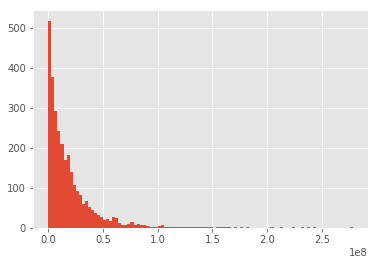

In [38]:
movies_by_actors.revenue.hist(bins=100)

同样是长尾分布，演员之间的票房差距没有导演之间的那么大。

#### 2.3.2 - 票房最高的主演Top 10

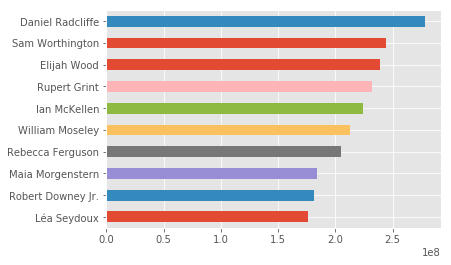

In [39]:
movies_by_actors.revenue.sort_values().tail(10).plot(kind = 'barh')

参演电影票房最高的是饰演哈利波特的丹尼尔，紧随其后的是出演了阿凡达的萨姆和出演了指环王的伊利亚伍德。

#### 2.3.3 - 演员的评分分布

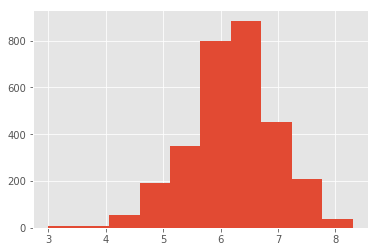

In [40]:
movies_by_actors.vote.hist()

与导演的情况类似，多数人的评分在6-7分之间。

#### 2.3.4 - 评分最高的演员Top 10

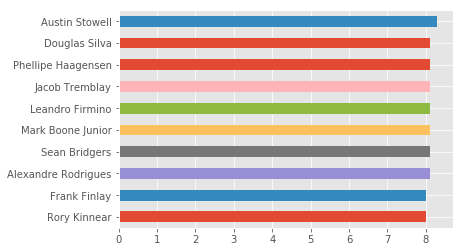

In [41]:
movies_by_actors.vote.sort_values().tail(10).plot(kind = 'barh')

前10名的差距不大，排名榜首的是出演了《爆裂鼓手》的奥斯汀·斯托维尔。

### 2.4 - 档期的影响

#### 2.4.1 - 档期的分布

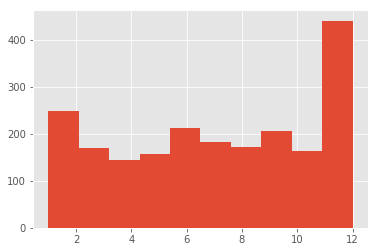

In [42]:
movies_15['month'] = pd.to_datetime(movies_credits['release_date']).apply(lambda x: x.month)
movies_15['day'] = pd.to_datetime(movies_credits['release_date']).apply(lambda x: x.day)
movies_15.month.hist()

1. 电影的出版方最喜欢在12月发布新片，其次是1月份。这两个月份的竞争会比较激烈。
2. 4月和5月电影的上映数量是最少的，竞争最小。  

来看看在12月份每一天的上映数量：

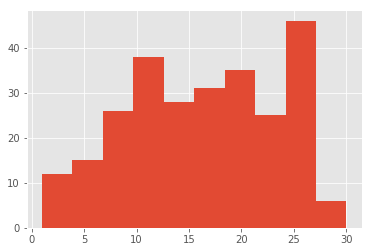

In [43]:
movies_15[movies_15.month == 12].day.hist()

圣诞节这一天上映的电影数量最多，在圣诞节前的两个星期竞争就开始变得激烈了。

#### 2.4.2 - 票房与档期的关系

计算每个月单部影片的平均票房：

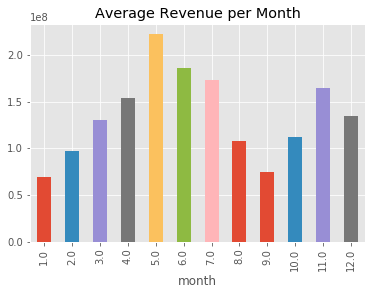

In [44]:
revenue_month = movies_15.groupby('month').revenue.sum() / movies_15.groupby('month').size()
revenue_month.plot(kind='bar', title='Average Revenue per Month')

1. 5月份的电影的平均票房最高，1月份的平均票房最低。
2. 4月和5月上映的电影数量少，平均票房高，是新电影安排档期的最佳选择。

#### 2.4.3 - 评分与档期的关系

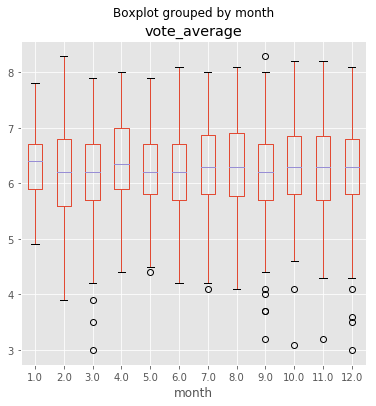

In [45]:
movies_15.boxplot(column = 'vote_average', by = 'month', figsize=(6,6))

每个月的评分都在6.5左右，受月份的影响很小。

### 2.5 - 有趣的发现

数据分析这一节到此结束，下面汇总一些比较有趣的发现：  
1. 电影的投资回报率在稳步上升，至2015年约为2.5倍，电影行业前景光明。
2. 电影票房与评分的相关性不大。
3. 动画片是平均票房最高的影片类型，但位于票房最顶端的往往是科幻+动作片。剧情片数量最多，但票房表现平平。
4. 如果预算有限又想获得高收益，纪录片是非常好的选择。
5. 4月和5月是上映影片的最佳档期，竞争小，容易获得高票房。

## 3 - 评分预测器

在这一节我们尝试构造一个评分的预测器。为什么这里不做票房预测器呢？因为票房还需要考虑大环境（经济环境、电影行业趋势）的影响，基于这个数据集提供的数据，对评分可以进行更准确的预测。

预测思路：假设评分的主要影响因素是影片类型、导演和主演，对于待预测的影片，筛选出这3个因素与之相似程度最高的5部影片，计算它们的平均评分，作为待预测影片的评分。

### 3.1 - 相似程度计算

计算方法：以类型为例，假设现有3中影片类型（科幻、动作、剧情），A影片为科幻+动作，B影片为动作，构造一个二元数组来表示影片的类型，A影片为[1, 1, 0]，B影片为[0, 1, 0]。两部影片的相似程度可以用它们的向量夹角（cos（A, B））来表示，值越大说明越不相似。

首先对于每部影片都构造二元数组表示类型、导演和主演：

In [46]:
def binary(wordlist0, wordlist):
    binary = []
    for word in wordlist0.index:
        if word in wordlist:
            binary.append(1)
        else:
            binary.append(0)
    return binary
movies_15['genres_bin'] = [binary(genres, x) for x in movies_15.genres]    #影片类型的二元数组
directors = movies_15.groupby('director').size().sort_values(ascending=False)
movies_15['director_bin'] = [binary(directors, x) for x in movies_15.director]    #影片导演的二元数组
actors = pd.Series(countN(movies_15.actors)).sort_values(ascending=False)
movies_15['actors_bin'] = [binary(actors, x) for x in movies_15.actors]    #影片主演的二元数组

定义一个函数计算两部影片的夹角（即不相似度）：

In [47]:
from scipy import spatial
def angle(movie1, movie2):
    dis_tot = 0
    iterlist = [[movie1.genres_bin, movie2.genres_bin],
                [movie1.director_bin, movie2.director_bin],
                [movie1.actors_bin, movie2.actors_bin]]                
    for b1, b2 in iterlist:
        if (1 not in b1) or (1 not in b2):
            dis = 1
        else:
            dis = spatial.distance.cosine(b1, b2)
        dis_tot += dis
    return dis_tot

找3部影片试验一下距离计算的效果。movies_15数据集中，第1部影片是《阿凡达》，第6部影片是《蜘蛛侠3》，第7部影片是《长发公主》

In [48]:
angle(movies_15.iloc[0], movies_15.iloc[5])    #《阿凡达》与《蜘蛛侠3》的夹角

2.1339745962155616

In [49]:
angle(movies_15.iloc[0], movies_15.iloc[6])    #《阿凡达》与《长发公主》的夹角

3.0

计算结果表明《阿凡达》与《蜘蛛侠3》更相似，实际也正是这样，因为他们都是动作片。

### 3.2 - 评分预测

定义一个函数，对于给定的一部影片，计算它与movies_15中所有影片的夹角，选出相似度最高的5部计算评分平均值：

In [50]:
def predictor(new_movie):
    movie_bin = pd.Series()
    movie_bin['genres_bin'] = binary(genres, new_movie['genres'])
    movie_bin['director_bin'] = binary(directors, new_movie['director'])
    movie_bin['actors_bin'] = binary(actors, new_movie['actors'])
    vote = movies_15.copy()
    vote['angle'] = [angle(vote.iloc[i], movie_bin) for i in range(len(vote))]
    vote = vote.sort_values('angle')
    vote_avg = np.mean(vote.vote_average[0:5])
    return vote_avg

《正义联盟》是2017年上映的电影，不在这个数据集中，我们来预测一下它的评分吧！将它的类型、导演和演员记入一个字典中：

In [51]:
Justice_league = {'genres': ['Action', 'Adventure', 'Fantasy', 'Science Fiction'], 'director': ['Zack Snyder'], 'actors': ['Ben Affleck', 'Henry Cavill', 'Amy Adams', 'Gal Gadot', 'Ezra Miller']}

In [52]:
predictor(Justice_league)

6.640000000000001

IMDb上《正义联盟》的评分是6.6分，我们的预测值6.64可以说是非常准确了！

再接再厉，《敦刻尔克》也是2017年才上映的电影，不在这个数据集中，我们来预测一下它的评分：

In [53]:
Dunkirk = {'genres': ['Action', 'Drama', 'History', 'Thriller', 'War'], 'director': ['Christopher Nolan'], 'actors': ['Fionn Whitehead', 'Damien Bonnard', 'Aneurin Barnard', 'Lee Armstrong', 'James Bloor']}

In [54]:
predictor(Dunkirk)

7.88

IMDb上《敦刻尔克》的评分是8.0分，我们的预测值是7.88，准确度还是挺高的。

如果大家喜欢这个评分预测器，可以将我的代码放到自己的Python上运行。Enjoy yourself!